In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
import spatial_maps as sm
import scipy

from tqdm import tqdm
from models import FFGC, RNNGC
from plotting_functions import *
from dataset import DatasetMaker

import umap.umap_ as umap
import plotly.express as px
from sklearn.decomposition import PCA

from ripser import ripser
from persim import plot_diagrams

/Users/m/miniforge3/envs/ml/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/m/miniforge3/envs/ml/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/m/miniforge3/envs/ml/lib/python3.9/site-packages/umap/distances.py:1086: NumbaD

## RNN

In [2]:
# Model parameters
timesteps = 10
ng = 256 # no. of recurrent units
# alpha = 0.88

In [3]:
# instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNNGC(ng = ng)
model = model.load("./saved-models/RNNGC_49999.pkl")

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

((50000, 10, 256), (256, 64, 64))

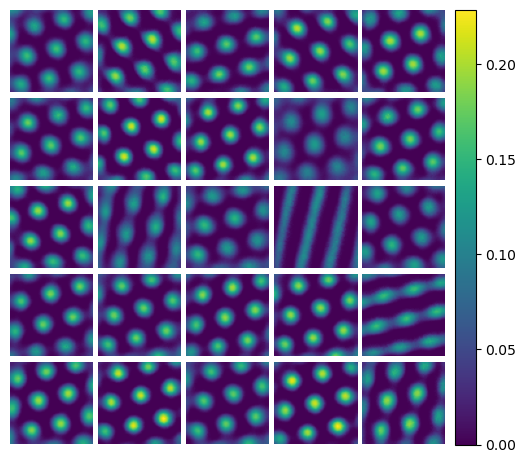

In [4]:
dataset = DatasetMaker()
rt, vt = dataset.generate_data(50000, 10)

rt = rt.to(device)
vt = vt.to(device)

bins = 64

g = model((rt[:,0], vt)).cpu().detach().numpy() # double check that states are alright
g_ratemaps = scipy.stats.binned_statistic_2d(rt[...,0].ravel().cpu().numpy(), rt[...,1].ravel().cpu().numpy(), g.reshape(-1, g.shape[-1]).T, bins = bins)[0]

multiimshow(g_ratemaps[:25], figsize=(5,5));
g.shape, g_ratemaps.shape

Text(0.5, 0, 'Grid Score')

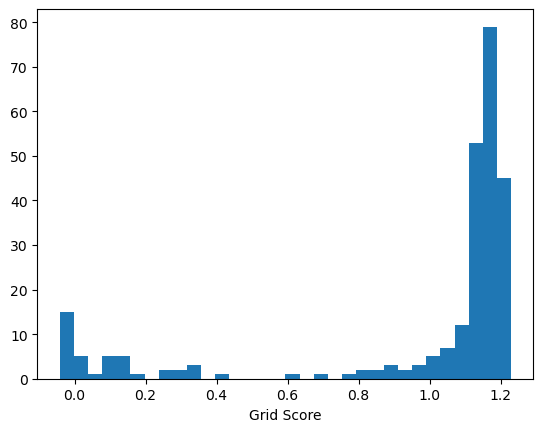

In [5]:
grid_score = np.array([sm.gridness(g_ratemaps[i]) for i in range(len(g_ratemaps))])
plt.hist(grid_score, bins = 32)
plt.xlabel("Grid Score")

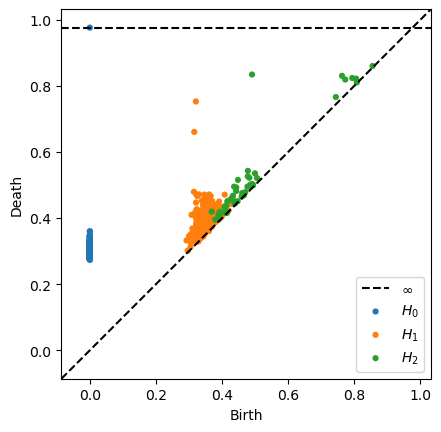

In [6]:
dgms = ripser(g_ratemaps.reshape(g_ratemaps.shape[0],-1).T, maxdim = 2, n_perm = 300)["dgms"]
plot_diagrams(dgms, show=True)

In [7]:
activity = g_ratemaps.reshape(g_ratemaps.shape[0], -1)
activity.shape

(256, 4096)

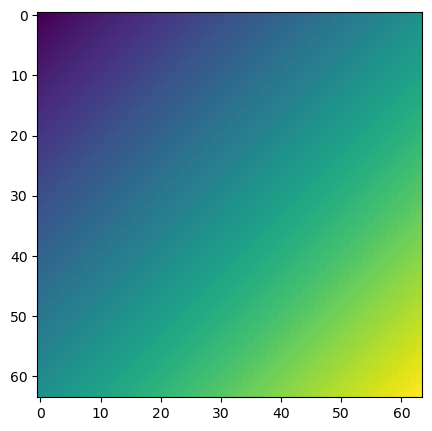

In [8]:
xcol = np.arange(0,int(np.sqrt(activity.shape[-1])))
ycol = np.arange(0,int(np.sqrt(activity.shape[-1])))

xx, yy = np.meshgrid(xcol,ycol)
cols = xx + yy
cols_flat = cols.flatten()

# Plot colormap of cols
fig = plt.figure(figsize=(5,5))
plt.imshow(cols)
plt.show()

In [9]:
n_neighbors = 2000
n_components = 3
plot = True

reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist= 0.8)
reducer.fit(activity.T)
embedding = reducer.transform(activity.T)


In [10]:
if plot and n_components==2:
    plt.scatter(embedding[:,0],embedding[:,1],s=10)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of the activity of the grid cells', fontsize=12)
    plt.show()
elif plot and n_components==3:
    fig = px.scatter_3d(x=embedding[:,0], y=embedding[:,1], z=embedding[:,2],color=cols_flat, color_continuous_scale = "Viridis")
    fig.show()

In [11]:
reducer = PCA(n_components=n_components)
reducer.fit(activity.T)
embedding = reducer.transform(activity.T)
print(embedding.shape)
# Explained variance
print(f"Explained variance for PCA with {n_components} components: {100*np.sum(reducer.explained_variance_ratio_):.3f} %")
if plot and n_components==2:
    plt.scatter(embedding[:,0],embedding[:,1],s=10)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('PCA projection of the activity of the grid cells', fontsize=12)
    plt.show()
elif plot and n_components==3:
    fig = px.scatter_3d(embedding, x=0, y=1, z=2,opacity=1,color=cols_flat, color_continuous_scale = "Viridis")
    fig.show()

(4096, 3)
Explained variance for PCA with 3 components: 48.473 %


## FF

In [25]:
model = FFGC()
model = model.load("./saved-models/FFGC_100000.pkl")

model.to(device)
pass

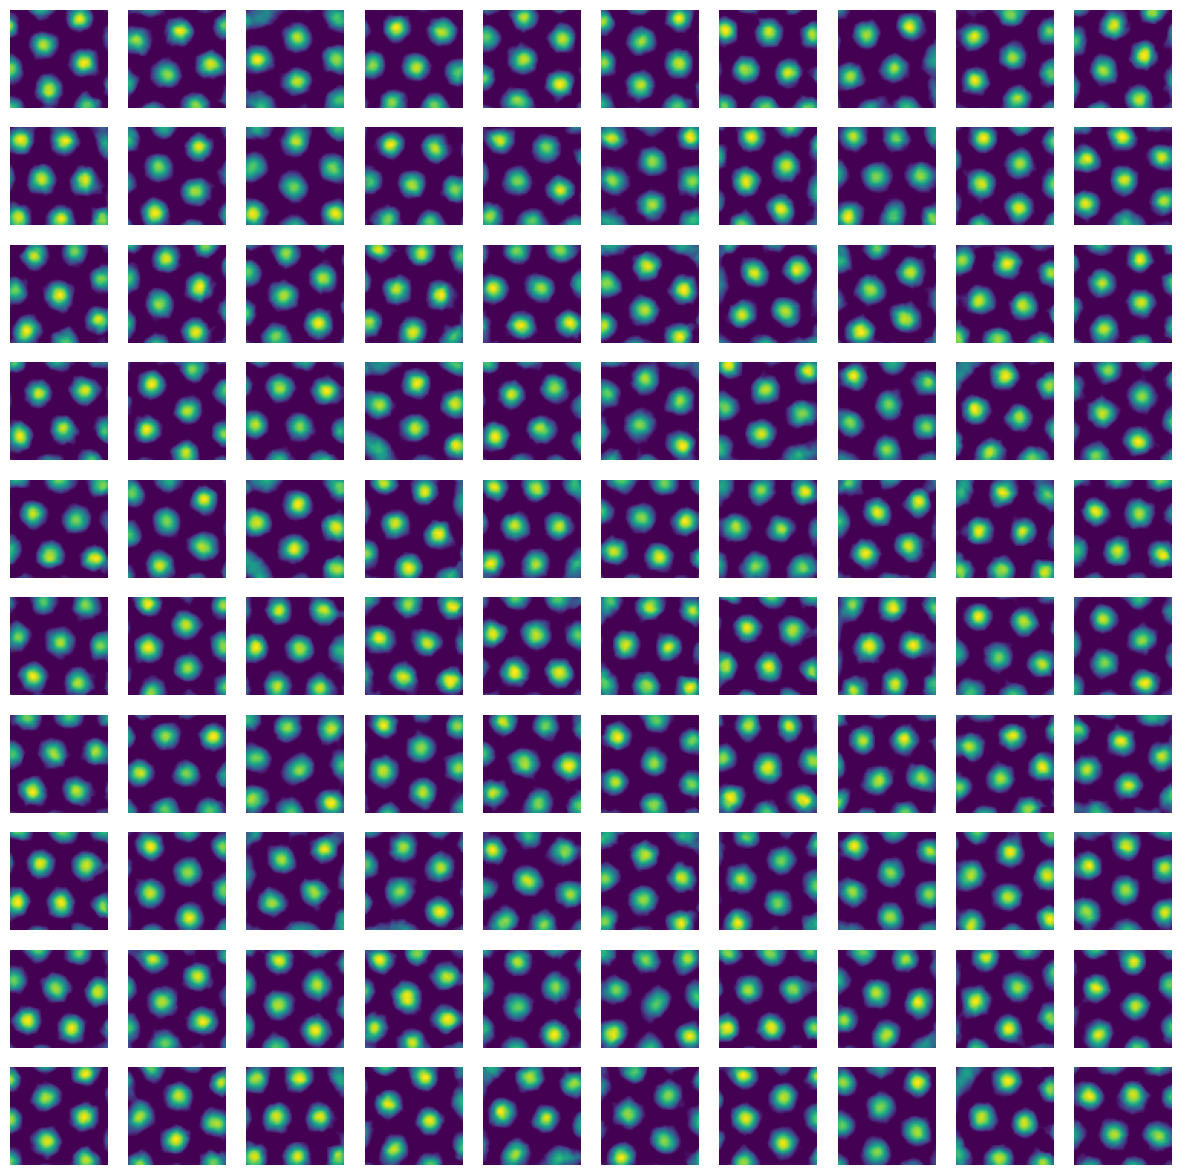

In [26]:
# evaluate on 64x64 grid
bins = 64
x = np.linspace(-1, 1, bins)*2*np.pi*0.8
y = np.linspace(-1, 1, bins)*2*np.pi*0.8
xx, yy = np.meshgrid(x,y)
r = np.stack([xx.ravel(), yy.ravel()], axis = -1)
gs = model(torch.tensor(r.astype("float32"),device = device))
gs = gs.detach().cpu().numpy()

ns = 10 # ns x ns grid of unit ratemaps
count = 0
fig ,ax = plt.subplots(ns,ns, figsize = (15,15))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(gs[...,count].reshape(bins, bins))
        ax[i,j].axis("off")
        count += 1

(array([  6.,   2.,   3.,   0.,   6.,   2.,   2.,   3.,  47., 185.]),
 array([-0.09271298,  0.04171639,  0.17614575,  0.31057512,  0.44500448,
         0.57943385,  0.71386321,  0.84829258,  0.98272194,  1.11715131,
         1.25158067]),
 <BarContainer object of 10 artists>)

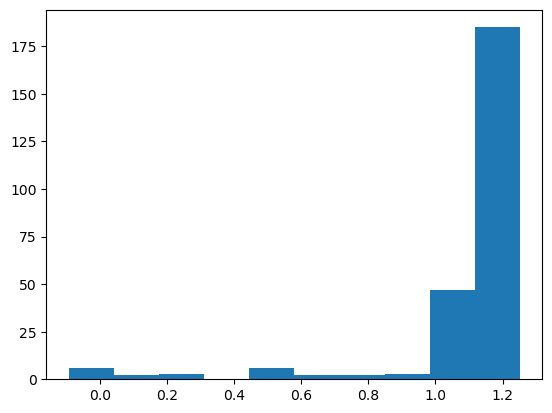

In [27]:
gs = gs.T.reshape(-1,bins,bins)
grid_score = np.array([sm.gridness(gs[i]) for i in range(len(gs))])
plt.hist(grid_score)

In [28]:
gs = gs[np.sum(gs, axis = (-2, -1)) > 0]
acorrs = np.array([sm.autocorrelation(g) for g in gs])
gs.shape
# acorrs = acorrs[grid_score > 0.5]
# gs = gs[grid_score > 0.5]

(256, 64, 64)

In [29]:
peaks = [sm.find_peaks(acorr) for acorr in acorrs]
spacings = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[0] for peak in peaks])
orientations = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[1] for peak in peaks])

((256,), (256, 64, 64))

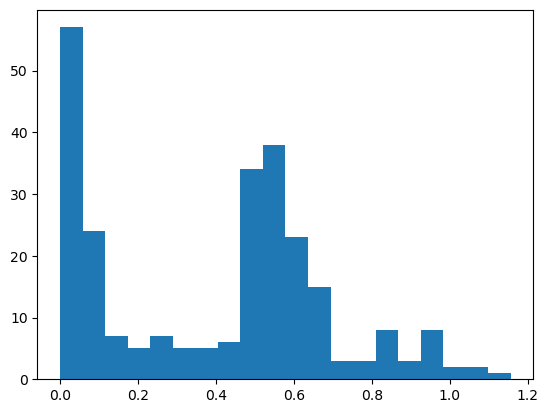

In [30]:
plt.hist(orientations, bins = 20)
orientations.shape, gs.shape
# plt.show()

In [31]:
gs_big_o = gs[orientations > 0.45]
gs_mid_o = gs[(orientations > 0.4) & (orientations < 0.8)]
gs_low_o = gs[(orientations < 0.05) + (orientations > 0.96)]

# activity_low_o = gs_low_o.reshape(gs_low_o.shape[0], -1)
activity_mid_o = gs_mid_o.reshape(gs_mid_o.shape[0], -1)
# activity_big_o = gs_big_o.reshape(gs_big_o.shape[0], -1)
# activity_mid_o.shape

In [32]:
gs_mid_o.T.shape

(64, 64, 124)

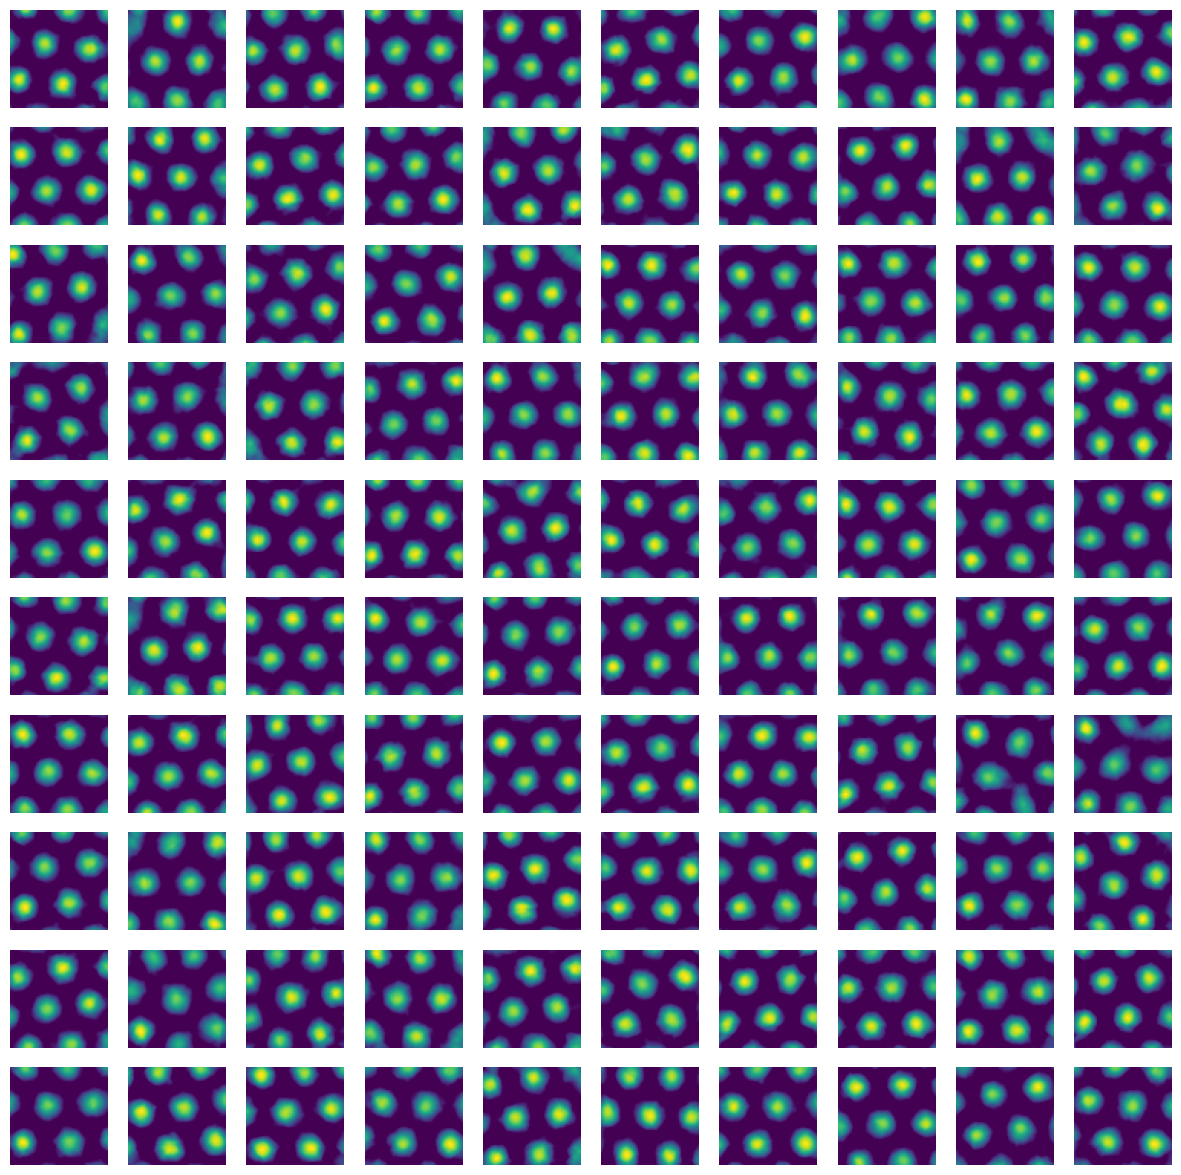

In [33]:
ns = 10 # ns x ns grid of unit ratemaps
count = 0
fig ,ax = plt.subplots(ns,ns, figsize = (15,15))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(gs_mid_o.T[...,count].reshape(bins, bins))
        ax[i,j].axis("off")
        count += 1

In [34]:
n_neighbors = 2000
n_components = 3
plot = True

reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist = 0.8)
reducer.fit(activity_mid_o.T)
embedding = reducer.transform(activity_mid_o.T)

pca = PCA(n_components=n_components)
col = pca.fit_transform(activity_mid_o.T)


In [35]:
if plot and n_components==2:
    plt.scatter(embedding[:,0],embedding[:,1],s=10)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of the activity of the grid cells', fontsize=12)
    plt.show()
elif plot and n_components==3:
    fig = px.scatter_3d(x=embedding[:,0], y=embedding[:,1], z=embedding[:,2],opacity = 1,color=col[:,0], color_continuous_scale = "Viridis")
    fig.show()

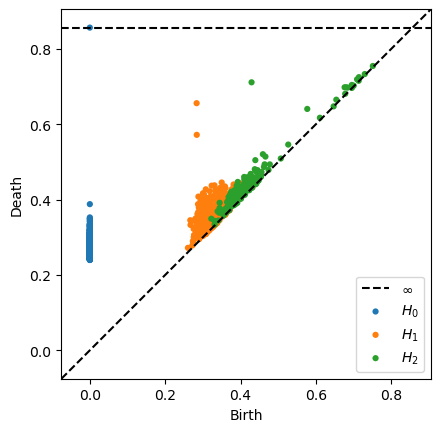

In [36]:
dgms = ripser(activity_mid_o.T, n_perm = 500,  maxdim=2, coeff = 47)["dgms"]#, coeff=47, metric = "cosine")['dgms']
plot_diagrams(dgms, show=True)

In [38]:
reducer = PCA(n_components=n_components)
reducer.fit(activity_mid_o.T)
embedding = reducer.transform(activity_mid_o.T)
print(embedding.shape)
# Explained variance
print(f"Explained variance for PCA with {n_components} components: {100*np.sum(reducer.explained_variance_ratio_):.3f} %")
if plot and n_components==2:
    plt.scatter(embedding[:,0],embedding[:,1],s=10)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('PCA projection of the activity of the grid cells', fontsize=12)
    plt.show()
elif plot and n_components==3:
    fig = px.scatter_3d(embedding, x=0, y=1, z=2,opacity=0.4,color=cols_flat,color_continuous_scale = "Viridis")
    fig.show()

(4096, 3)
Explained variance for PCA with 3 components: 44.123 %
